# 종합실습2_1 따릉이

* 지금까지 배운 것을 총 복습 합니다.
* Data : 서울 공유 자전거
* 문제 : 2시간 후의 수요를 예측하고자 한다.

## 1.환경준비

### (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session
from tensorflow.keras.optimizers import Adam

* 함수 만들기

In [2]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err')
    plt.plot(history['val_loss'], label='val_err')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터로딩

In [3]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/SeoulBikeData2.csv'
data = pd.read_csv(path)
data['DateTime'] = pd.to_datetime(data['DateTime'], format='%Y-%m-%d %H:%M:%S')
data.drop(['Visibility','Solar'], axis = 1, inplace = True)
data.head()

,DateTime,Count,Temperature,Humidity,WindSpeed,Rainfall,Snowfall,Seasons,Holiday,FuncDay
0,2017-12-01 00:00:00,254,-5.2,37,2.2,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01 01:00:00,204,-5.5,38,0.8,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01 02:00:00,173,-6.0,39,1.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-12-01 03:00:00,107,-6.2,40,0.9,0.0,0.0,Winter,No Holiday,Yes
4,2017-12-01 04:00:00,78,-6.0,36,2.3,0.0,0.0,Winter,No Holiday,Yes


**변수설명**  

* DateTime : year-month-day hh:mi:ss
* Count : 시간대별 수요량
* Temperature : 온도(섭씨)
* Humidity : 습도(%)
* WindSpeed : 풍속(m/s)
* Visibility : 가시거리(단위: 10m)
* Solar - 태양복사열, MJ/m2
* Rainfall - mm
* Snowfall - cm
* Seasons - Winter, Spring, Summer, Autumn
* Holiday - Holiday / No holiday
* FuncDay - Yes / No


In [4]:
# 데이터 기간은 다음과 같습니다.
data.DateTime.min(), data.DateTime.max()

(Timestamp('2017-12-01 00:00:00'), Timestamp('2018-11-30 23:00:00'))

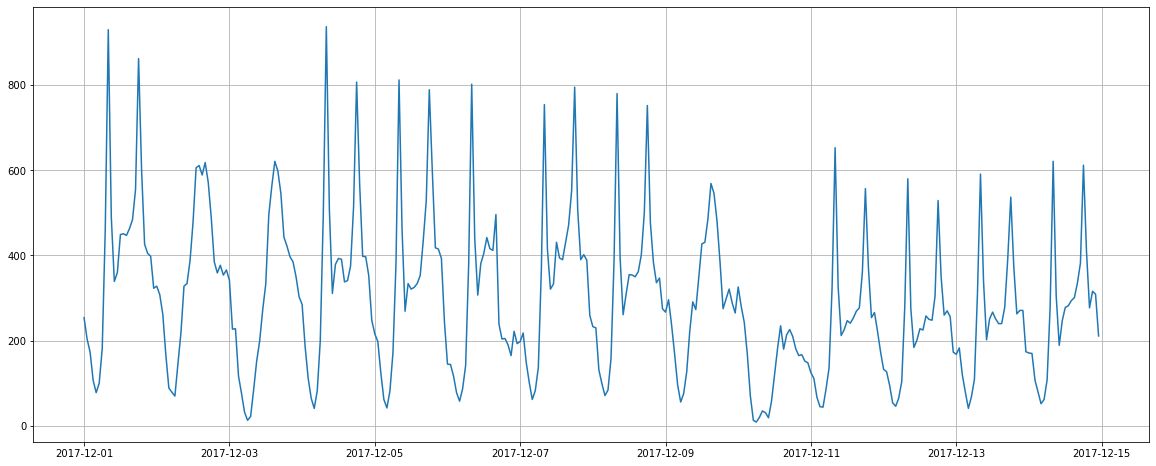

In [5]:
# 14일 동안의 수요량을 살펴 봅시다.
temp = data[:24*14]
plt.figure(figsize = (20,8))
plt.plot('DateTime', 'Count', data = temp)
plt.grid()
plt.show()

## 2.데이터 준비

### (1) y 만들기 
* 2시간 이후의 수요량을 예측해야 합니다.

In [6]:
data['y'] = data['Count'].shift(-2) # 두 행 뒤의 값을 가져옴 
data.head()

,DateTime,Count,Temperature,Humidity,WindSpeed,Rainfall,Snowfall,Seasons,Holiday,FuncDay,y
0,2017-12-01 00:00:00,254,-5.2,37,2.2,0.0,0.0,Winter,No Holiday,Yes,173.0
1,2017-12-01 01:00:00,204,-5.5,38,0.8,0.0,0.0,Winter,No Holiday,Yes,107.0
2,2017-12-01 02:00:00,173,-6.0,39,1.0,0.0,0.0,Winter,No Holiday,Yes,78.0
3,2017-12-01 03:00:00,107,-6.2,40,0.9,0.0,0.0,Winter,No Holiday,Yes,100.0
4,2017-12-01 04:00:00,78,-6.0,36,2.3,0.0,0.0,Winter,No Holiday,Yes,181.0


In [7]:
# 2칸을 앞당겼기 때문에 하위 2행의 y값에 NaN이 표시되어 있습니다.
data.tail()

,DateTime,Count,Temperature,Humidity,WindSpeed,Rainfall,Snowfall,Seasons,Holiday,FuncDay,y
8755,2018-11-30 19:00:00,1003,4.2,34,2.6,0.0,0.0,Autumn,No Holiday,Yes,694.0
8756,2018-11-30 20:00:00,764,3.4,37,2.3,0.0,0.0,Autumn,No Holiday,Yes,712.0
8757,2018-11-30 21:00:00,694,2.6,39,0.3,0.0,0.0,Autumn,No Holiday,Yes,584.0
8758,2018-11-30 22:00:00,712,2.1,41,1.0,0.0,0.0,Autumn,No Holiday,Yes,NaN
8759,2018-11-30 23:00:00,584,1.9,43,1.3,0.0,0.0,Autumn,No Holiday,Yes,NaN


In [8]:
# 하위 2행은 삭제합니다.
# 하위 2행 제외하고 다시 붓기
data = data.iloc[:-2]

### (2) 데이터 분할1 : x, y 나누기

In [9]:
target = 'y'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

### (3) feature engineering
* 여기서는 다루지 않습니다.

In [10]:
# 날짜 데이터 제거
x.drop('DateTime', axis = 1, inplace = True)
x.head()

,Count,Temperature,Humidity,WindSpeed,Rainfall,Snowfall,Seasons,Holiday,FuncDay
0,254,-5.2,37,2.2,0.0,0.0,Winter,No Holiday,Yes
1,204,-5.5,38,0.8,0.0,0.0,Winter,No Holiday,Yes
2,173,-6.0,39,1.0,0.0,0.0,Winter,No Holiday,Yes
3,107,-6.2,40,0.9,0.0,0.0,Winter,No Holiday,Yes
4,78,-6.0,36,2.3,0.0,0.0,Winter,No Holiday,Yes


### (4) NaN 조치

### (5) 가변수화

In [11]:
cat_cols = ['Seasons','Holiday','FuncDay']
x = pd.get_dummies(x, columns = cat_cols, drop_first = True)

### (6) 데이터분할2 : train : val

* 시계열 데이터이므로 시간의 흐름에 맞게 분할합시다.
* 뒤에서 30일 : validaiton
* 나머지 : train
* 30일 : 시간단위 데이터이므로 24 * 30


In [12]:
i = 30 * 24
x_train, x_val = x[:-i], x[-i:]
y_train, y_val = y[:-i], y[-i:]

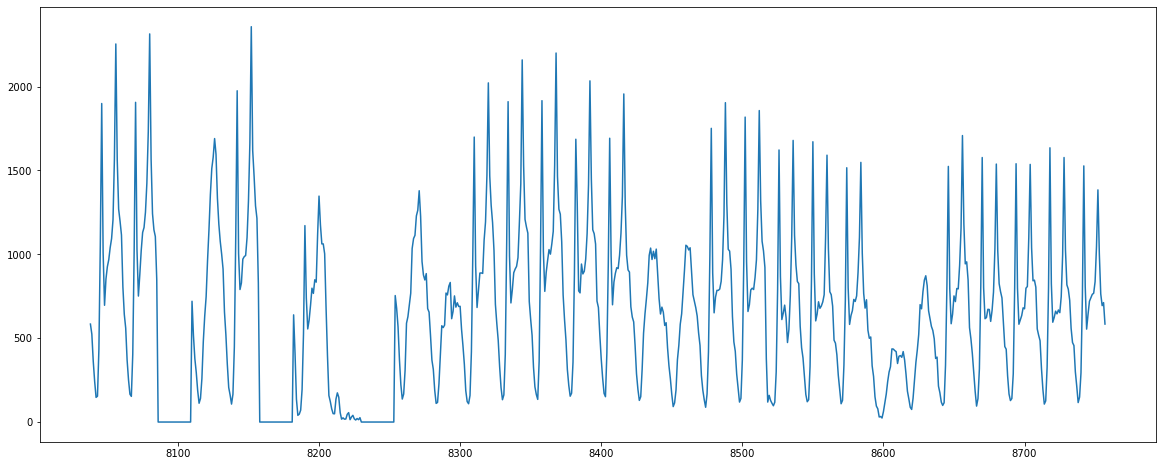

In [13]:
plt.figure(figsize = (20,8))
plt.plot(y_val)
plt.show()

### (7) Scaling

In [14]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

* y 값이 클 경우 scaling 하면 학습에 도움이 됩니다.

In [15]:
# 딥러닝에서는 y값도 스케일링 하는 경우가 있다. 
# min max scaling을 수동으로 수행합니다.
y_train_min = y_train.min()
y_train_max = y_train.max()

y_train_s = (y_train - y_train_min) / (y_train_max - y_train_min)

## 3.모델링
* 딥러닝 모델을 최소 2개 이상을 생성하고 성능을 비교해 봅시다.


* 모델1

In [29]:
nfeatures = x.shape[1]
nfeatures

11

In [30]:
# 1) 모델 구조 설계
clear_session()

model = Sequential([Dense(32, input_shape=(nfeatures,), activation = 'relu'),
                    Dense(16, activation='relu'),
                    Dense(8, activation='relu'),
                    Dense(1, )])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                384       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,057
Trainable params: 1,057
Non-trainable params: 0
_________________________________________________________________


In [31]:
# 2) 컴파일
model.compile(optimizer=Adam(lr=0.001), loss='mse')

C:\Users\User\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [32]:
# 3) 학습 
history = model.fit(x_train, y_train_s, epochs=100, validation_split=0.2 ).history 

Epoch 1/100
201/201 [==============================] - 1s 3ms/step - loss: 0.0218 - val_loss: 0.0364
Epoch 2/100
201/201 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0278
Epoch 3/100
201/201 [==============================] - 0s 2ms/step - loss: 0.0102 - val_loss: 0.0263
Epoch 4/100
201/201 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0221
Epoch 5/100
201/201 [==============================] - 0s 2ms/step - loss: 0.0098 - val_loss: 0.0218
Epoch 6/100
201/201 [==============================] - 1s 3ms/step - loss: 0.0098 - val_loss: 0.0220
Epoch 7/100
201/201 [==============================] - 1s 3ms/step - loss: 0.0096 - val_loss: 0.0232
Epoch 8/100
201/201 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.0213
Epoch 9/100
201/201 [==============================] - 1s 3ms/step - loss: 0.0095 - val_loss: 0.0208
Epoch 10/100
201/201 [==============================] - 1s 3ms/step - loss: 0.0095 - val_lo

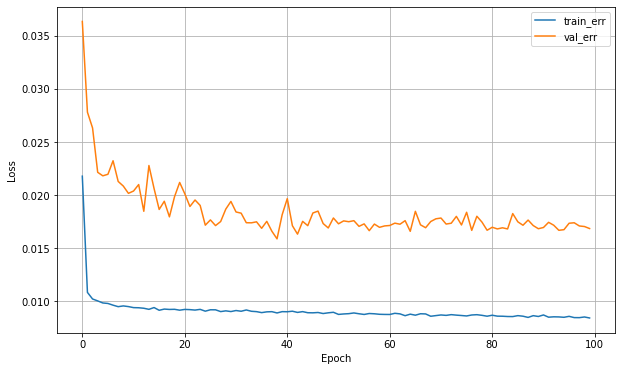

In [33]:
# 4) 학습곡선 
dl_history_plot(history)

In [36]:
# 정규화된 값 예측 전에 원래대로 돌려놓기 
p1 = model.predict(x_val)
p1 
p1_real = p1 * (y_train.max() - y_train.min() ) + y_train.min() 
p1_real

23/23 [==============================] - 0s 3ms/step


array([[ 938.4333  ],
       [ 743.33466 ],
       [ 668.06604 ],
       [ 700.7322  ],
       [ 690.7831  ],
       [ 587.6102  ],
       [ 457.35666 ],
       [ 466.87308 ],
       [ 800.0831  ],
       [ 908.4861  ],
       [1007.2011  ],
       [ 824.04785 ],
       [ 756.9411  ],
       [1081.1404  ],
       [1384.2065  ],
       [1395.0781  ],
       [1561.794   ],
       [1640.6941  ],
       [1675.7473  ],
       [1709.1436  ],
       [1816.0294  ],
       [1492.4727  ],
       [1306.0989  ],
       [1130.2418  ],
       [ 847.8127  ],
       [ 784.62006 ],
       [ 734.2436  ],
       [ 802.7184  ],
       [ 690.20404 ],
       [ 624.43976 ],
       [ 543.6774  ],
       [ 502.27292 ],
       [ 759.22723 ],
       [ 881.4904  ],
       [1106.0211  ],
       [ 822.88007 ],
       [ 840.12915 ],
       [1120.0826  ],
       [1392.6056  ],
       [1531.2427  ],
       [1630.5663  ],
       [1703.513   ],
       [1681.2877  ],
       [1659.202   ],
       [1847.7119  ],
       [16

In [71]:
# 5) 검증 : 예측 
pred = model.predict(x_val)
print(mean_squared_error(y_val, p1_real))
print(mean_absolute_error(y_val, p1_real))

23/23 [==============================] - 0s 2ms/step
128205.23274562467
260.5836773389743


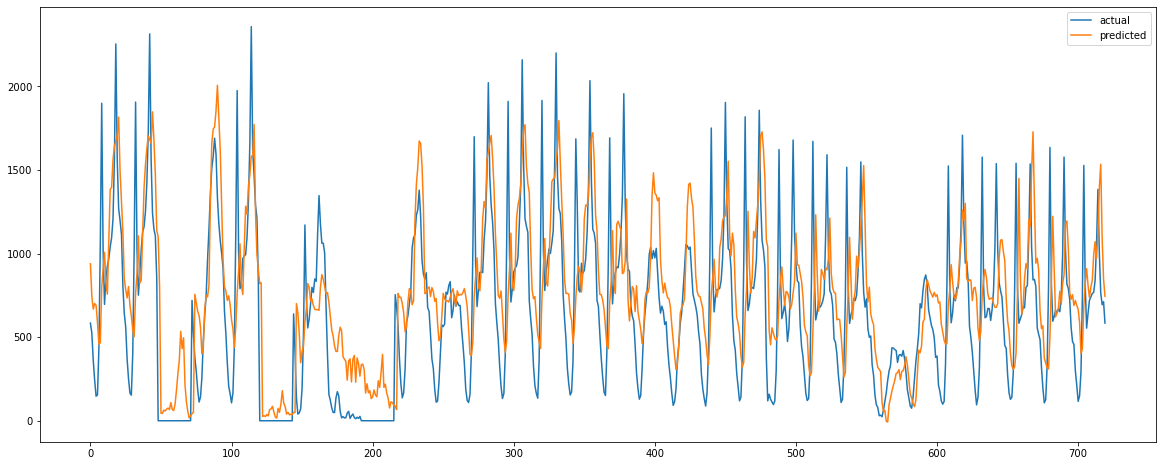

In [40]:
# 6) 검증 : 평가 
plt.figure(figsize = (20,8)) 
plt.plot(y_val.values, label = 'actual' ) 
plt.plot(p1_real, label = 'predicted') 
plt.legend() 
plt.show()

* 모델2

In [29]:
nfeatures = x.shape[1]
nfeatures

11

In [64]:
# 1) 모델 구조 설계
clear_session()

model2 = Sequential([Dense(8, input_shape = (nfeatures, ),activation='relu'),
                     Dense(8, activation='relu'),
                     Dense(4, activation='relu'),
                     Dense(1, )])

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 96        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 209
Trainable params: 209
Non-trainable params: 0
_________________________________________________________________


In [65]:
# 2) 컴파일
model2.compile(optimizer=Adam(lr=0.001), loss='mse')

C:\Users\User\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [66]:
# 3) 학습 
history = model2.fit(x_train, y_train_s, epochs=100, validation_split=0.2 ).history 

Epoch 1/100
201/201 [==============================] - 1s 4ms/step - loss: 0.0516 - val_loss: 0.0516
Epoch 2/100
201/201 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0435
Epoch 3/100
201/201 [==============================] - 0s 2ms/step - loss: 0.0121 - val_loss: 0.0380
Epoch 4/100
201/201 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0361
Epoch 5/100
201/201 [==============================] - 0s 2ms/step - loss: 0.0111 - val_loss: 0.0300
Epoch 6/100
201/201 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0307
Epoch 7/100
201/201 [==============================] - 0s 2ms/step - loss: 0.0106 - val_loss: 0.0266
Epoch 8/100
201/201 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.0252
Epoch 9/100
201/201 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0236
Epoch 10/100
201/201 [==============================] - 0s 2ms/step - loss: 0.0104 - val_lo

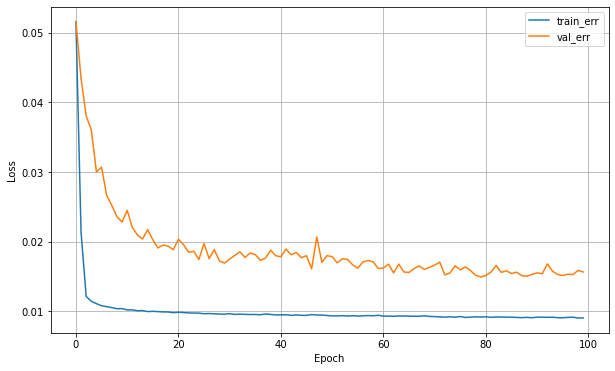

In [67]:
# 4) 학습곡선 
dl_history_plot(history)

In [68]:
# 정규화된 값 예측 전에 원래대로 돌려놓기 
p2 = model2.predict(x_val)
p2 
p2_real = p2 * (y_train.max() - y_train.min() ) + y_train.min() 
p2_real

23/23 [==============================] - 0s 2ms/step


array([[ 7.88822510e+02],
       [ 6.94144836e+02],
       [ 6.00301880e+02],
       [ 5.62119385e+02],
       [ 3.97061493e+02],
       [ 2.03297379e+02],
       [ 8.43363876e+01],
       [ 2.80789928e+01],
       [ 3.15284454e+02],
       [ 6.25107605e+02],
       [ 7.52476624e+02],
       [ 7.05097717e+02],
       [ 6.66683655e+02],
       [ 7.60602234e+02],
       [ 7.83326660e+02],
       [ 8.24427246e+02],
       [ 9.86759399e+02],
       [ 1.07909412e+03],
       [ 1.21904053e+03],
       [ 1.36181323e+03],
       [ 1.74600378e+03],
       [ 1.04943994e+03],
       [ 8.36860718e+02],
       [ 7.95484558e+02],
       [ 7.12072876e+02],
       [ 6.66455505e+02],
       [ 6.20715576e+02],
       [ 5.23447693e+02],
       [ 3.39715027e+02],
       [ 1.99426254e+02],
       [ 1.33659592e+02],
       [ 7.40487671e+01],
       [ 3.43897095e+02],
       [ 6.45975769e+02],
       [ 7.83453430e+02],
       [ 7.26019409e+02],
       [ 7.10033691e+02],
       [ 7.87995056e+02],
       [ 8.8

In [70]:
# 5) 검증 : 예측 
pred = model2.predict(x_val)
print(mean_squared_error(y_val, p2_real))
print(mean_absolute_error(y_val, p2_real))

23/23 [==============================] - 0s 2ms/step
140976.68278833543
247.8743716676202


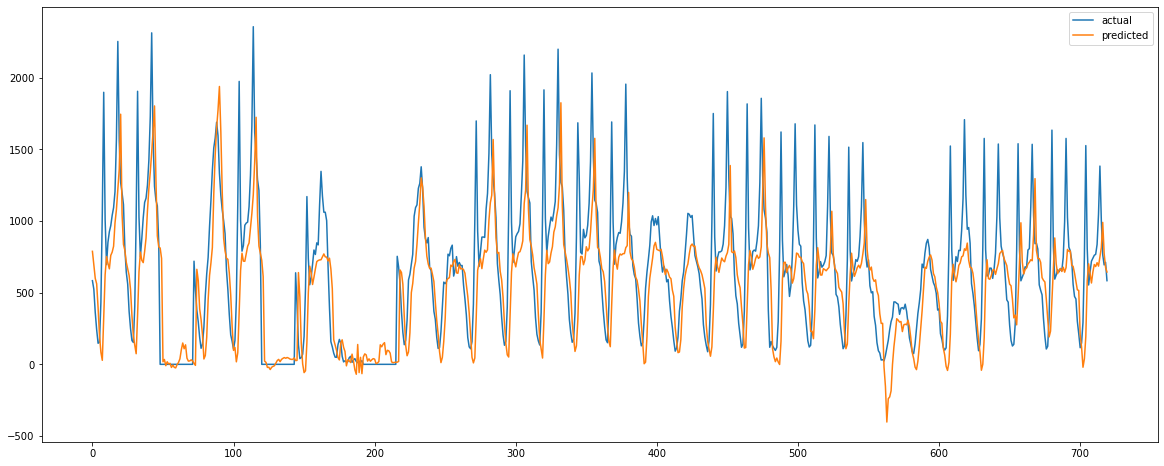

In [72]:
# 6) 검증 : 평가 
plt.figure(figsize = (20,8)) 
plt.plot(y_val.values, label = 'actual' ) 
plt.plot(p2_real, label = 'predicted') 
plt.legend() 
plt.show()